In [1]:
%matplotlib notebook

import pickle
import pandas
import numpy
from matplotlib import pyplot

In [2]:
root = '/scr-ssd/mimic/'
clinic_file = lambda i: root + 'clinic-data/{}.csv'.format(i.upper())

In [3]:
with open(root + 'headers_matched.pkl', 'rb') as f:
    hdrs = pickle.load(f)

In [4]:
date_cols = ['DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN']
patients = pandas.read_csv(clinic_file('patients'), parse_dates=date_cols)
patients.set_index('SUBJECT_ID', verify_integrity=True, inplace=True)
patients[:5]

,ROW_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
SUBJECT_ID,,,,,,,
249,234,F,2075-03-13,NaT,NaT,NaT,0
250,235,F,2164-12-27,2188-11-22,2188-11-22,NaT,1
251,236,M,2090-03-15,NaT,NaT,NaT,0
252,237,M,2078-03-06,NaT,NaT,NaT,0
253,238,F,2089-11-26,NaT,NaT,NaT,0


In [5]:
date_cols = ['ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'EDREGTIME', 'EDOUTTIME']
admissions = pandas.read_csv(clinic_file('admissions'), parse_dates=date_cols)
admissions.set_index('HADM_ID', verify_integrity=True, inplace=True)
admissions[10:15]

,ROW_ID,SUBJECT_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
HADM_ID,,,,,,,,,,,,,,,,,,
175413,31,32,2170-04-04 08:00:00,2170-04-23 12:45:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Medicaid,NaN,UNOBTAINABLE,NaN,WHITE,NaT,NaT,TRACHEAL STENOSIS/SDA,0,1
176176,32,33,2116-12-23 22:30:00,2116-12-27 12:05:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,NaN,PROTESTANT QUAKER,MARRIED,UNKNOWN/NOT SPECIFIED,2116-12-23 14:42:00,2116-12-23 23:41:00,SEPSIS;TELEMETRY,0,1
115799,33,34,2186-07-18 16:46:00,2186-07-20 16:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,CHEST PAIN\CATH,0,1
144319,34,34,2191-02-23 05:23:00,2191-02-25 20:20:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,2191-02-23 04:23:00,2191-02-23 07:25:00,BRADYCARDIA,0,1
166707,35,35,2122-02-10 11:15:00,2122-02-20 15:30:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,NaT,NaT,AORTIC VALVE DISEASE\CORONARY ARTERY BYPASS GR...,0,1


In [6]:
date_cols = ['INTIME', 'OUTTIME']
icustays = pandas.read_csv(clinic_file('icustays'), parse_dates=date_cols)
icustays.set_index('ICUSTAY_ID', verify_integrity=True, inplace=True)
icustays[:5]

,ROW_ID,SUBJECT_ID,HADM_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
ICUSTAY_ID,,,,,,,,,,,
280836,365,268,110404,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
206613,366,269,106296,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
220345,367,270,188028,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
249196,368,271,173727,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
210407,369,272,164716,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [7]:
_extract_record_id = lambda hdr: int(hdr['seg_name'][0].split('_')[0])
_extract_subject_id = lambda hdr: int(hdr['record_name'].split('-')[0][1:])

to_subject_id = {
    _extract_record_id(i): _extract_subject_id(i) for i in hdrs
    if i['record_name'][0] == 'p' and i['record_name'][-1] != 'n'
}

to_base_date = {
    _extract_record_id(i): i['base_date'] for i in hdrs 
    if i['record_name'][0] == 'p' and i['record_name'][-1] != 'n'
}

In [8]:
metadata = []
for i in hdrs:
    if i['record_name'][0] != 'p':
        rec_id, seg = [int(j) for j in i['record_name'].split('_')]
        datum = {
            'subject_id': to_subject_id[rec_id],
            'record_id': rec_id,
            'segment': seg,
            'time': pandas.Timestamp.combine(to_base_date[rec_id], i['base_time']),
            'sig_len': i['sig_len'],
            'sig_name': tuple(sorted(i['sig_name']))
        }
        metadata.append(datum)

metadata = pandas.DataFrame(metadata)
metadata.set_index(['record_id', 'segment'], verify_integrity=True, inplace=True)
metadata[:10]

subject_id                    time  sig_len  \
record_id segment                                                
3544749   1                20 2183-04-28 17:48:00.230     3811   
          2                20 2183-04-28 17:48:30.714      124   
          3                20 2183-04-28 17:48:31.706        8   
          4                20 2183-04-28 17:48:31.770      380   
          5                20 2183-04-28 17:48:34.810  7098177   
          6                20 2183-04-28 09:35:00.230    15000   
          7                20 2183-04-28 09:37:00.230    30000   
          8                20 2183-04-28 09:41:00.230  2715000   
3524877   1                30 2172-10-16 12:22:07.132   450000   
3713820   1                33 2116-12-24 12:35:06.147    15000   

                              sig_name  
record_id segment                       
3544749   1        (ABP, AVF, II, PAP)  
          2        (ABP, AVF, II, PAP)  
          3        (ABP, AVF, II, PAP)  
          4        (ABP, AVF, II, PAP)  
          5        (ABP, AVF, II, PAP)  
          6                  (AVF, II)  
          7             (ABP, AVF, II)  
          8                  (AVF, II)  
3524877   1                    (II, V)  
3713820   1                 (II, MCL1)

In [9]:
time_cols = ['ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'EDREGTIME', 'EDOUTTIME']
matched_subject_ids = sorted(set(to_subject_id.values()))
times = admissions.reset_index().set_index(['SUBJECT_ID', 'HADM_ID'])[time_cols]
times = times.loc[matched_subject_ids]
times.index = times.index.rename(['subject_id', 'hadm_id'])
admission_ranges = pandas.DataFrame({'low': times.min(axis=1), 'high': times.max(axis=1)})
admission_ranges.loc[matched_subject_ids[10:15]]

low                high
subject_id hadm_id                                        
125        157348  2179-02-14 21:23:00 2179-02-21 18:03:00
135        192180  2173-05-17 15:27:00 2173-05-26 14:30:00
           199634  2174-05-17 09:00:00 2174-05-21 14:00:00
138        108120  2131-10-31 08:00:00 2131-11-06 12:54:00
           188284  2133-12-21 23:52:00 2134-01-11 13:00:00
           105764  2134-03-01 07:15:00 2134-03-07 11:44:00
145        198161  2144-03-28 23:46:00 2144-07-14 16:15:00
           138459  2145-02-15 00:24:00 2145-02-22 13:30:00
154        111735  2117-12-29 19:02:00 2118-01-01 14:27:00
           162891  2118-04-05 18:11:00 2118-04-11 14:21:00
           102354  2127-12-23 18:46:00 2127-12-26 13:50:00

In [10]:
time = metadata.reset_index().set_index(['subject_id', 'record_id', 'segment'])['time']
record_ranges = pandas.DataFrame({
    'low': time.min(level=['subject_id', 'record_id']),
    'high': time.max(level=['subject_id', 'record_id']),
})
record_ranges.loc[matched_subject_ids[:5]]

low                    high
subject_id record_id                                                
20         3544749   2183-04-28 09:35:00.230 2183-04-28 17:48:34.810
30         3524877   2172-10-16 12:22:07.132 2172-10-16 12:22:07.132
33         3713820   2116-12-24 12:35:06.147 2116-12-24 20:07:44.405
           3737936   2116-12-25 13:12:07.902 2116-12-25 13:12:07.902
52         3238451   2191-01-10 02:21:23.248 2191-01-10 10:57:35.208
           3533390   2191-01-10 01:04:20.616 2191-01-10 22:30:06.616
79         3842928   2175-09-26 01:27:02.384 2175-09-26 12:05:02.384
           3887555   2175-09-26 11:34:34.904 2175-09-26 15:16:34.800

In [11]:
def get_range_matches(r1, r2):
    x1 = r1[['low']].values
    x2 = r1[['high']].values
    y1 = r2[['low']].values
    y2 = r2[['high']].values
    S = (x1 < y2.T) & (y1.T < x2)
    assert((S.sum(1) < 2).all())
    return {r1.index[i]: r2.index[j] for i, j in numpy.argwhere(S)}

In [12]:
%%time

hadm_ids = []
for i in matched_subject_ids:
    matches = get_range_matches(record_ranges.loc[i], admission_ranges.loc[i])
    hadm_ids += [{'record_id': k, 'hadm_id': matches[k]} for k in matches]

CPU times: user 35.9 s, sys: 24 ms, total: 36 s
Wall time: 35.9 s


In [13]:
hadm_df = pandas.DataFrame(hadm_ids).set_index('record_id')
metadata['hadm_id'] = hadm_df.reindex(metadata.index, level=0, fill_value=-1)

In [14]:
metadata['gender'] = patients['GENDER'][metadata['subject_id']].values
metadata['dob'] = patients['DOB'][metadata['subject_id']].values
age = metadata['time'].values - metadata['dob'].values
age = age.astype('timedelta64[Y]').astype('int')
age[age < 0] = 90
metadata['age'] = age

<IPython.core.display.Javascript object>


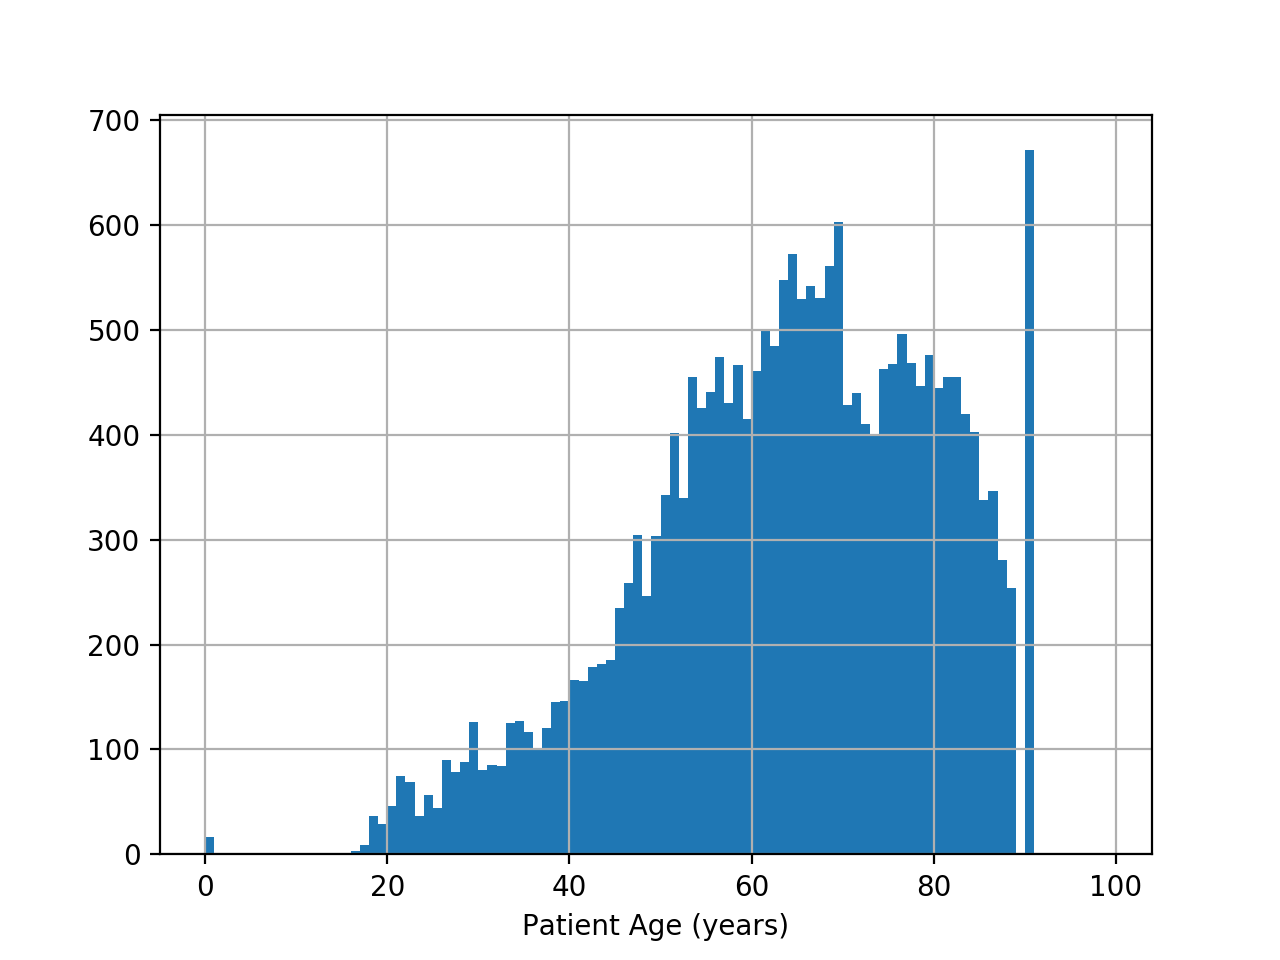

Text(0.5, 0, 'Patient Age (years)')

In [15]:
pyplot.figure()
metadata['age'][:,1].hist(bins=range(100)).set_xlabel('Patient Age (years)')

<IPython.core.display.Javascript object>


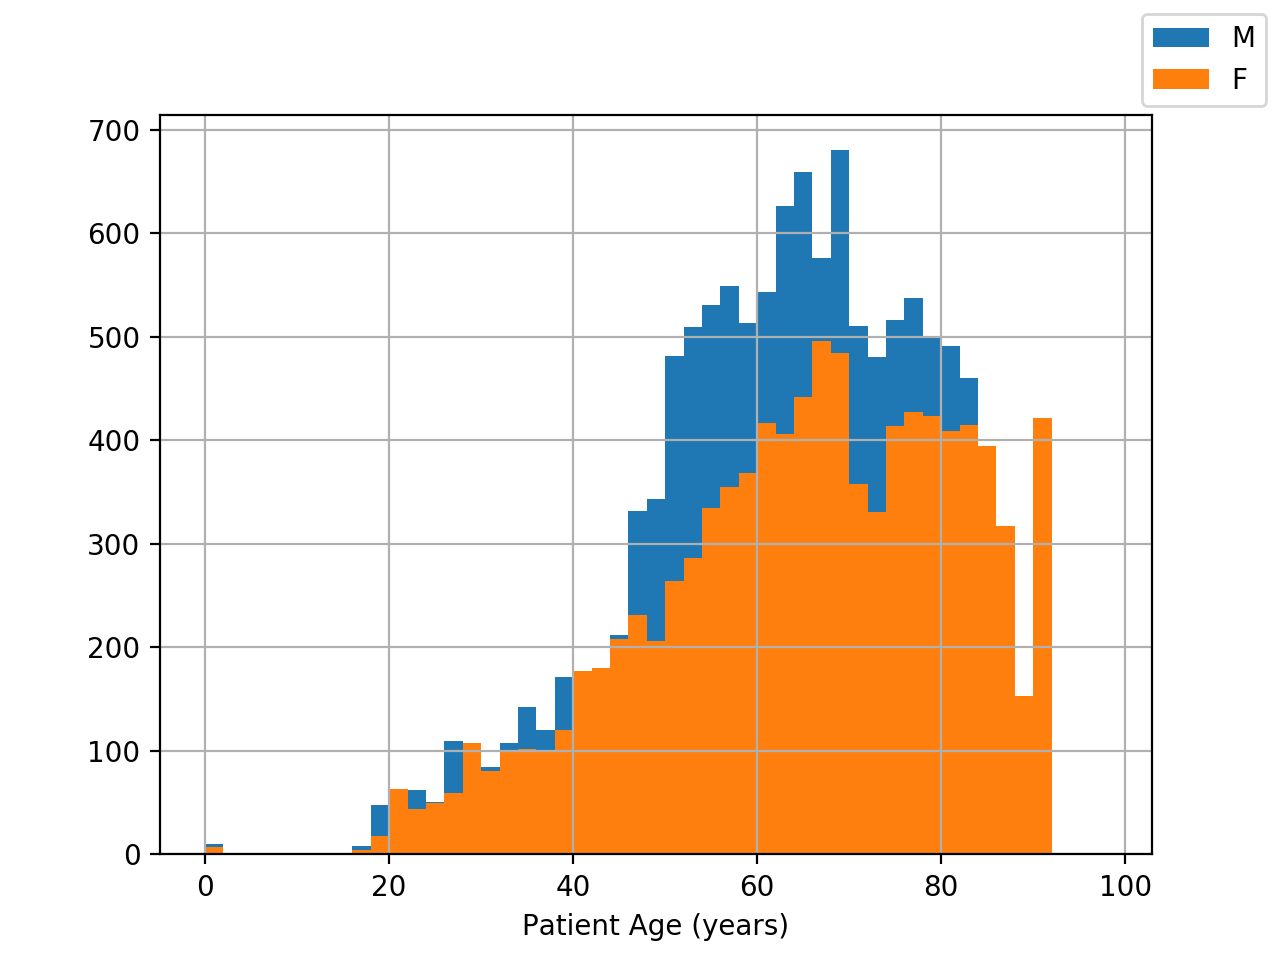

In [45]:
fig = pyplot.figure()
metadata['age'][metadata['gender']=='M'][:,1].hist(bins=range(0, 100, 2)).set_xlabel('Patient Age (years)')
metadata['age'][metadata['gender']=='F'][:,1].hist(bins=range(0, 100, 2)).set_xlabel('Patient Age (years)')
fig.legend(['M', 'F'])

In [16]:
metadata['gender'].value_counts()

M    492493
F    377779
Name: gender, dtype: int64

In [17]:
metadata['sig_name'].value_counts()[:10]

(AVR, II, PLETH, RESP, V)              165008
(ABP, AVR, II, PLETH, RESP, V)          67609
(ABP, AVR, CVP, II, PLETH, RESP, V)     33033
(II,)                                   31018
(II, MCL)                               29685
(V,)                                    27028
(II, PLETH)                             24895
(II, V)                                 24247
(II, III, PLETH, RESP, V)               20031
(AVR, II, RESP, V)                      18095
Name: sig_name, dtype: int64

In [19]:
input_mv = pandas.read_csv(clinic_file('inputevents_mv'), low_memory=False)

<IPython.core.display.Javascript object>


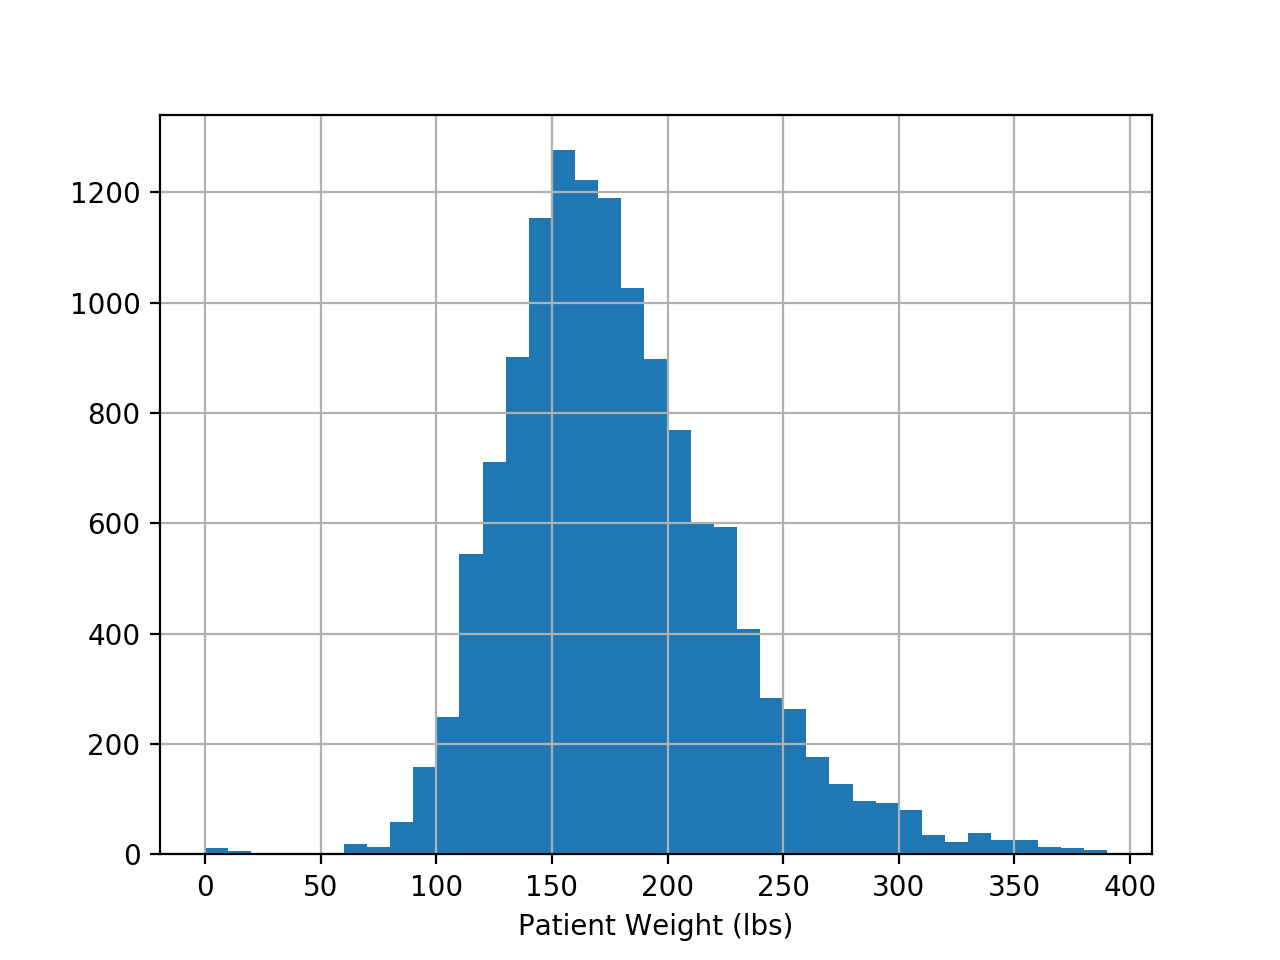

In [20]:
k = 'hadm_id'
weight = input_mv.drop_duplicates(k.upper())
weight = weight.set_index(k.upper(), verify_integrity=True)['PATIENTWEIGHT']
metadata['weight'] = weight.reindex(metadata[k]).values

pyplot.figure()
(metadata['weight'][:,1] * 2.2).hist(bins=range(0, 400, 10)).set_xlabel('Patient Weight (lbs)');

<IPython.core.display.Javascript object>


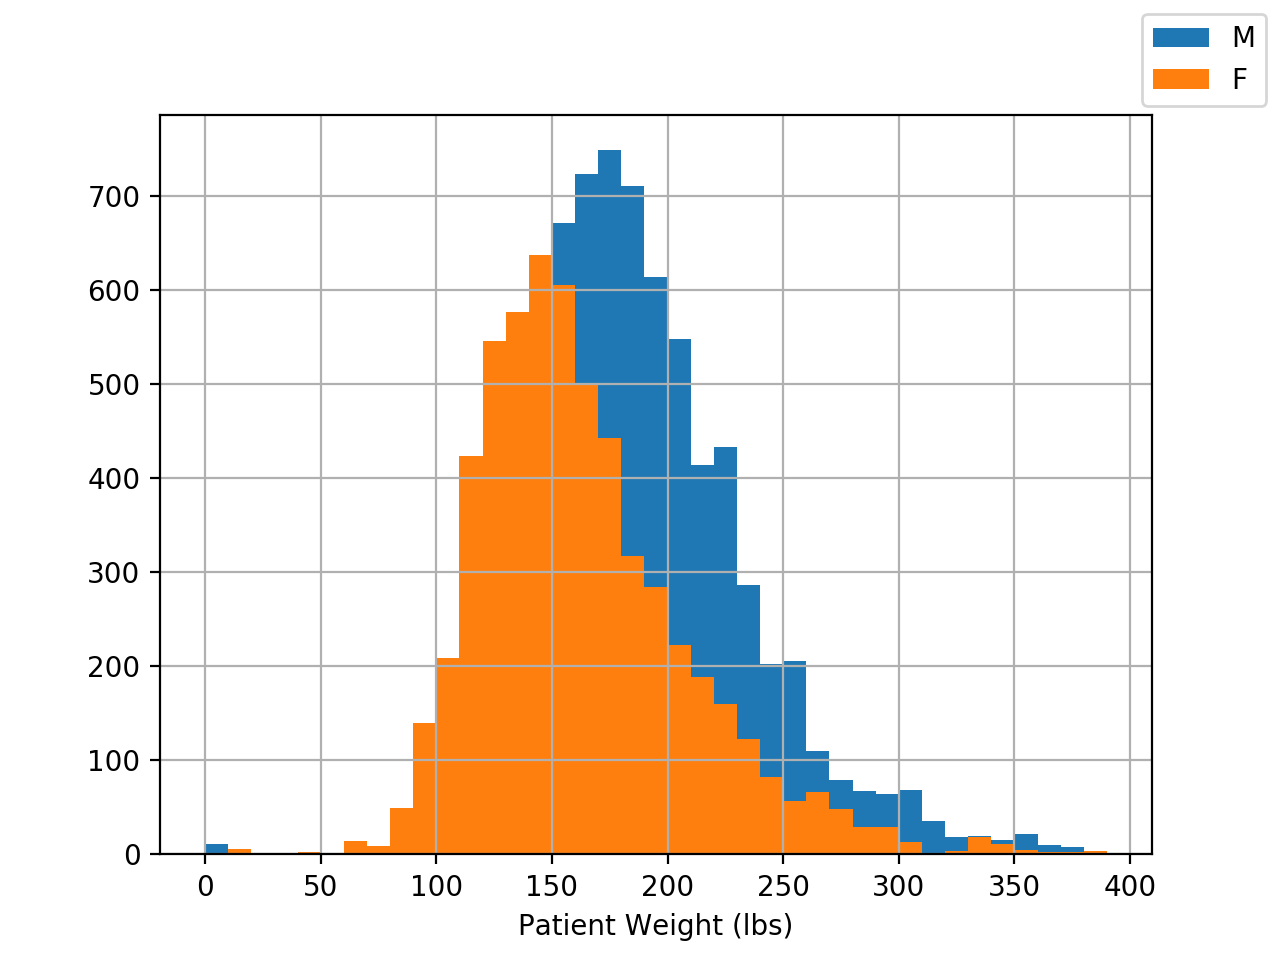

In [41]:
fig = pyplot.figure()
(metadata['weight'][metadata['gender'] == 'M'][:,1] * 2.2).hist(bins=range(0, 400, 10)).set_xlabel('Patient Weight (lbs)')
(metadata['weight'][metadata['gender'] == 'F'][:,1] * 2.2).hist(bins=range(0, 400, 10)).set_xlabel('Patient Weight (lbs)')
fig.legend(['M', 'F']);

In [21]:
notes = pandas.read_csv(clinic_file('noteevents'), low_memory=False)

In [24]:
parse_0 = lambda line: line.split('Height:')[1].split('Weight')[0].replace(' ', '')
parse_00 = lambda line: int(parse_0(line)[:2])

def parse_01(line):
    p0 = parse_0(line).split('"')[0].split("'")[:2]
    if p0[1] == '':
        p0[1] = '0'
    try:
        height = 12 * int(p0[0]) + int(float(p0[1]))
    except:
        height = None
    return height
    
parse_02 = lambda line: int(parse_0(line)[:2])

parse_03 = lambda line: int(parse_0(line)[4:6])

def parse_04(line):
    p0 = parse_0(line)
    ft = int(p0[0])
    try:
        inch = int(float(p0[5:].split('inch')[0].replace(',', '')))
    except:
        return
    return 12 * ft + inch

heights = []

for i in range(len(notes)):
    for line in notes['TEXT'][i].split('\n'):
        if 'Height:' in line and len(parse_0(line)):
            p0 = parse_0(line)
            datum = {'hadm_id': notes['HADM_ID'][i], 'subject_id': notes['SUBJECT_ID'][i]}
            if '[**' in line and '**]' in line:
                continue
            if len(p0) > 2 and p0[2] == '"':
                datum['height'] = parse_00(line)
                heights.append(datum)
            elif len(p0) > 1 and p0[1] == "\'":
                datum['height'] = parse_01(line)
                if datum['height'] is not None:
                    heights.append(datum)
            elif p0[2:6].lower() == 'inch':
                datum['height'] = parse_02(line)
                heights.append(datum)
            elif p0[:4] == '(in)':
                datum['height'] = parse_03(line)
                heights.append(datum)
            elif len(p0) > 9 and p0[1] == 'f' and p0[4] == 't' and 'inch' in p0:
                datum['height'] = parse_04(line)
                if datum['height'] is not None:
                    heights.append(datum)

In [28]:
k = 'hadm_id'
heights_df = pandas.DataFrame(heights).drop_duplicates(k)
heights_df = heights_df.set_index(k, verify_integrity=True)

<IPython.core.display.Javascript object>


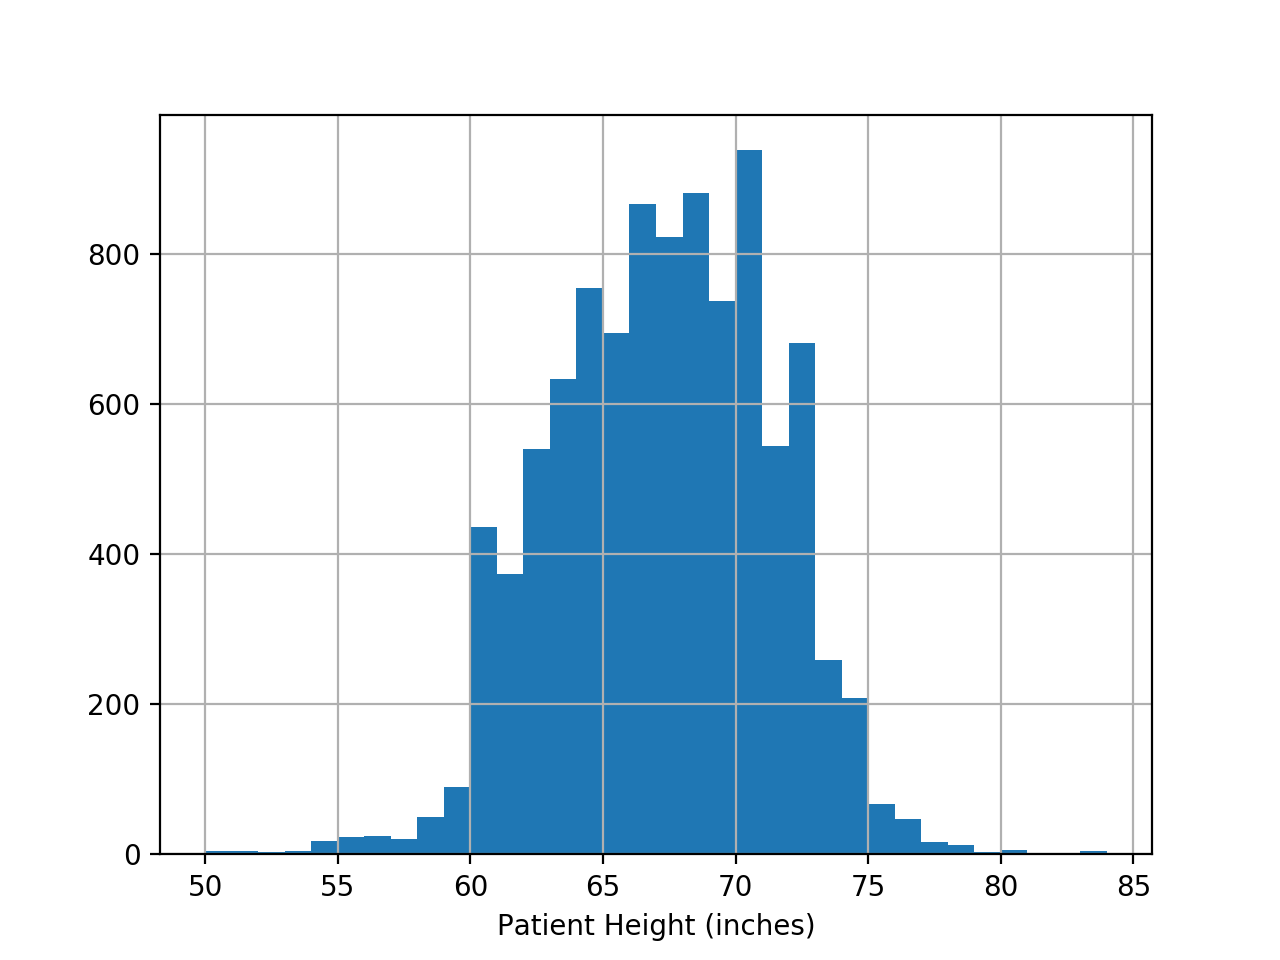

In [32]:
k = 'hadm_id'
heights_df = pandas.DataFrame(heights).drop_duplicates(k)
heights_df = heights_df.set_index(k, verify_integrity=True)
metadata['height'] = heights_df.reindex(metadata[k])['height'].values

pyplot.figure()
metadata['height'][:,1].hist(bins=range(50, 85)).set_xlabel('Patient Height (inches)');

<IPython.core.display.Javascript object>


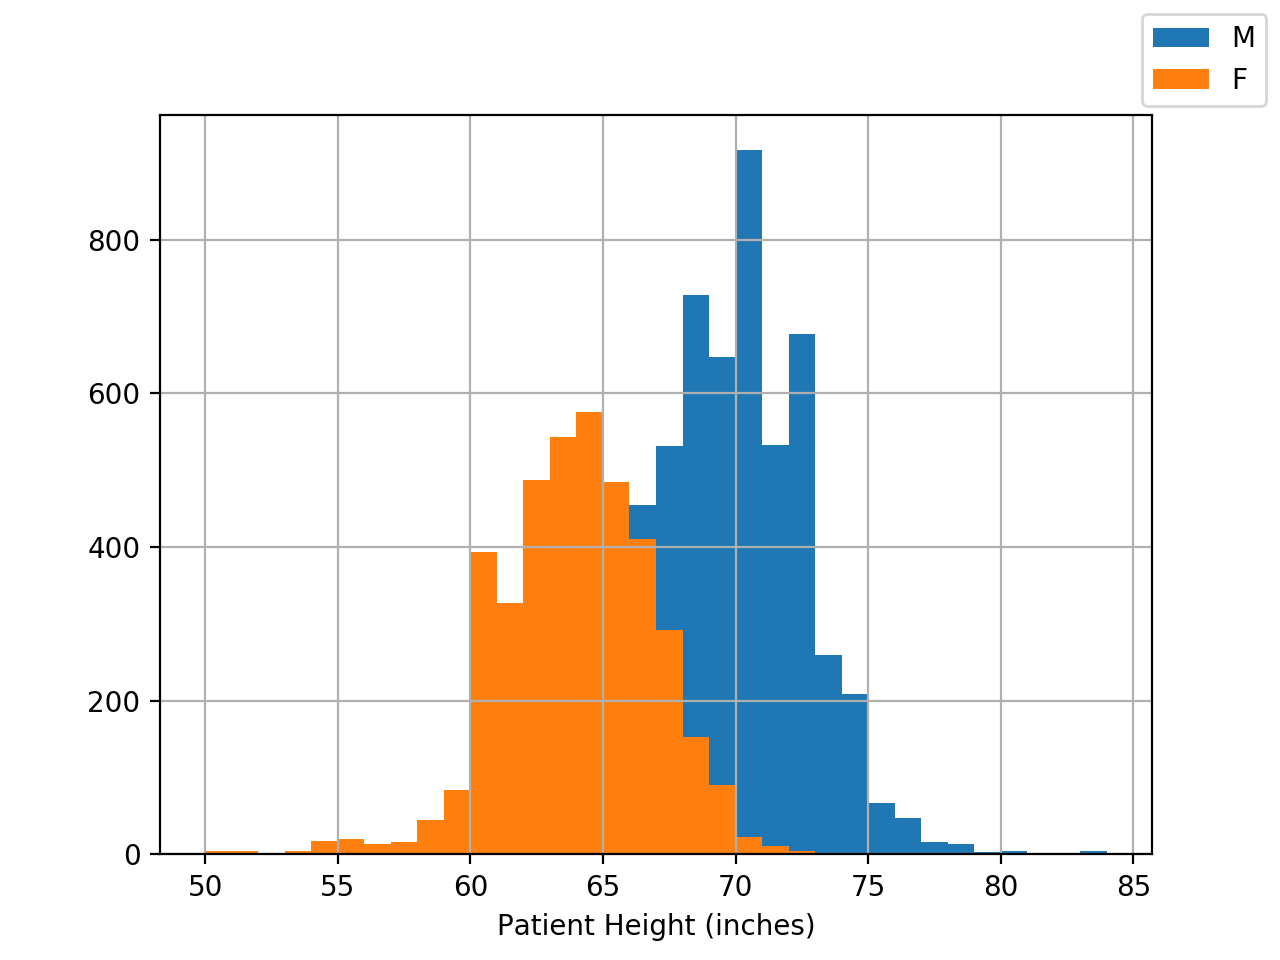

In [40]:
fig = pyplot.figure()
metadata['height'][metadata['gender'] == 'M'][:,1].hist(bins=range(50, 85)).set_xlabel('Patient Height (inches)');
metadata['height'][metadata['gender'] == 'F'][:,1].hist(bins=range(50, 85)).set_xlabel('Patient Height (inches)');
fig.legend(['M', 'F'])

In [37]:
metadata.to_csv('metadata.csv')

In [ ]:
cp metadata.csv metadata_backup.csv

In [43]:
metadata = pandas.read_csv('metadata_backup.csv')
diagnoses = pandas.read_csv(clinic_file('diagnoses_icd'))
diagnoses_info = pandas.read_csv(clinic_file('d_icd_diagnoses'))

In [44]:
diagnoses_info.set_index('ICD9_CODE').loc[['4019', '4280', '42731', '41401', '2724']]

,ROW_ID,SHORT_TITLE,LONG_TITLE
ICD9_CODE,,,
4019,4304,Hypertension NOS,Unspecified essential hypertension
4280,4473,CHF NOS,"Congestive heart failure, unspecified"
42731,4462,Atrial fibrillation,Atrial fibrillation
41401,4374,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...
2724,2747,Hyperlipidemia NEC/NOS,Other and unspecified hyperlipidemia


In [5]:
code_names = {
    '4019': 'hypertensive',
    '4280': 'congestive_heart_failure',
    '42731': 'atrial_fibrillation',
    '41401': 'coronary_atherosclerosis',
    '2724': 'hyperlipidemia',
}

In [46]:
metadata.set_index(['hadm_id', 'record_id', 'segment'], verify_integrity=True, inplace=True)
for code in code_names:
    diagnosed = diagnoses[diagnoses['ICD9_CODE'] == code]
    is_diagnosed = metadata.index.isin(diagnosed['HADM_ID'], level='hadm_id')
    metadata[code_names[code]] = False
    metadata.loc[is_diagnosed, code_names[code]] = True
    print(metadata[code_names[code]].sum())
metadata.reset_index(inplace=True)

304797
271239
257961
214154
185554


<IPython.core.display.Javascript object>


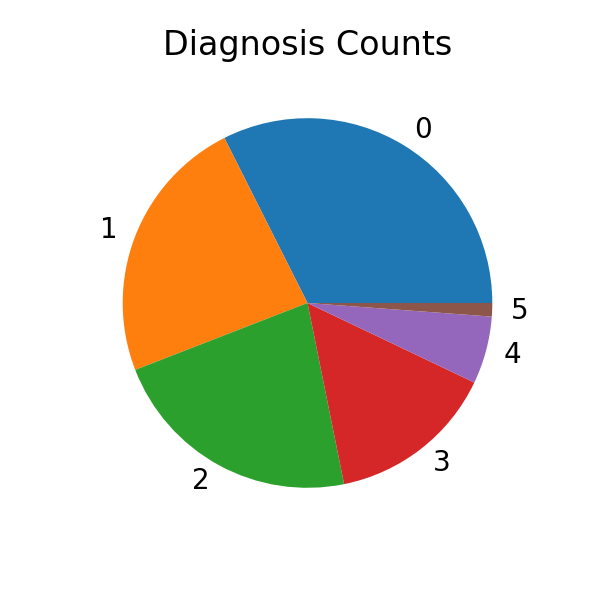

In [64]:
counts = metadata[code_names.values()].sum(axis=1).value_counts()
pyplot.figure(figsize=[3,3])
counts.plot.pie(label='', title='Diagnosis Counts')

### ICD Codes

In [34]:
diagnoses_info = pandas.read_csv(clinic_file('d_icd_diagnoses'))
diagnoses_info = diagnoses_info.drop(columns='ROW_ID').set_index('ICD9_CODE')
diagnoses = pandas.read_csv(clinic_file('diagnoses_icd')).drop(columns='ROW_ID')
counts = pandas.Series(diagnoses['ICD9_CODE'].value_counts(), name='COUNTS')
counts = pandas.concat([diagnoses_info.reindex(counts.index), counts], axis=1)

In [39]:
codes_heart = ['4019', '4589', '4280', '42731', '42732', '41401', '41400', '2724', '2720']
counts.loc[codes_heart]

,SHORT_TITLE,LONG_TITLE,COUNTS
4019,Hypertension NOS,Unspecified essential hypertension,20703
4589,Hypotension NOS,"Hypotension, unspecified",2051
4280,CHF NOS,"Congestive heart failure, unspecified",13111
42731,Atrial fibrillation,Atrial fibrillation,12891
42732,Atrial flutter,Atrial flutter,1217
41401,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,12429
41400,Cor ath unsp vsl ntv/gft,Coronary atherosclerosis of unspecified type o...,1494
2724,Hyperlipidemia NEC/NOS,Other and unspecified hyperlipidemia,8690
2720,Pure hypercholesterolem,Pure hypercholesterolemia,5930


In [41]:
codes_other = ['5859', '5856', '40390', '40391', '5119', '25000']
counts.loc[codes_other]

,SHORT_TITLE,LONG_TITLE,COUNTS
5859,Chronic kidney dis NOS,"Chronic kidney disease, unspecified",3435
5856,End stage renal disease,End stage renal disease,1926
40390,Hy kid NOS w cr kid I-IV,"Hypertensive chronic kidney disease, unspecifi...",3421
40391,Hyp kid NOS w cr kid V,"Hypertensive chronic kidney disease, unspecifi...",2630
5119,Pleural effusion NOS,Unspecified pleural effusion,2734
25000,DMII wo cmp nt st uncntr,Diabetes mellitus without mention of complicat...,9058


In [43]:
codes_mods = ['V4581', 'V4501', '45829']
counts.loc[codes_mods]

,SHORT_TITLE,LONG_TITLE,COUNTS
V4581,Aortocoronary bypass,Aortocoronary bypass status,3056
V4501,Status cardiac pacemaker,Cardiac pacemaker in situ,1390
45829,Iatrogenc hypotnsion NEC,Other iatrogenic hypotension,2121


In [3]:
metadata = pandas.read_csv('/scr-ssd/mimic/metadata.csv')

In [ ]:
icd_codes = pandas.read_csv(clinic_file('diagnoses_icd'))
icd_codes = icd_codes.drop(columns='ROW_ID')
icd_codes = icd_codes.set_index(['HADM_ID', 'SEQ_NUM'])
icd_codes = icd_codes.groupby(level='HADM_ID')
icd_codes = icd_codes.aggregate(list)
metadata['icd_codes'] = icd_codes['ICD9_CODE'].reindex(metadata['hadm_id']).values

In [10]:
cp /scr-ssd/mimic/metadata.csv /scr-ssd/mimic/metadata_backup.csv

In [11]:
metadata.drop(columns=code_names.values()).set_index(['record_id', 'segment']).to_csv('/scr-ssd/mimic/metadata.csv')

### Sig Data

In [ ]:
import pickle
hdrs = pickle.load(open('/scr-ssd/mimic/headers_matched.pkl', 'rb'))

keys = ['sig_name', 'baseline', 'adc_gain', 'adc_res', 'adc_zero', 'fmt', 'init_value', 'checksum', 'units']

sig_data_raw = [
    {
        'rec_id_prefix': int(i['record_name'].split('_')[0]),
        'segment': int(i['record_name'].split('_')[1]),
        'sig_index': j,
        **{k: i[k][j] for k in keys}
    }
    for i in hdrs if 'p' not in i['record_name'] for j in range(i['n_sig'])
]

sig_data = pandas.DataFrame(sig_data_raw)
sig_data.set_index(['rec_id_prefix', 'segment', 'sig_index'], verify_integrity=True, inplace=True)
sig_data.to_csv('/scr-ssd/mimic/sig_data.csv')